### Import Packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA
import numpy as np

### Use gpu if available

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Create DataLoader

In [3]:
# transform: normalize between -1 and 1 (because we are using tanh activation function)
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# load dataset
train_dataset = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=transforms)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)


### Vanilla GAN

#### Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, img_dim),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.model(x)

#### Encoder

In [5]:
class Encoder(nn.Module):
    def __init__(self, latent_dim, img_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(img_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, latent_dim)
        )
    
    def forward(self, x):
        return self.net(x)

#### Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self, img_dim, latent_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim + latent_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 1),
        )
    
    def forward(self, x, z):
        xz = torch.cat([x, z], dim=1)
        return self.model(xz)

### Craete Bi-GAN

In [7]:
# Initialize models
latent_dim = 100
img_dim = 28 * 28

generator = Generator(latent_dim=latent_dim, img_dim=img_dim).to(device)
encoder = Encoder(latent_dim=latent_dim, img_dim=img_dim).to(device)
discriminator = Discriminator(img_dim=img_dim, latent_dim=latent_dim).to(device)

# Optimizers with lower learning rate
g_e_optimizer = torch.optim.Adam(
    list(generator.parameters()) + list(encoder.parameters()), 
    lr=0.0001, 
    betas=(0.5, 0.999)
)
d_optimizer = torch.optim.Adam(
    discriminator.parameters(), 
    lr=0.0001, 
    betas=(0.5, 0.999)
)

# Loss function
criterion = nn.BCEWithLogitsLoss()

### Utils

In [8]:
def latent_to_image(z, image_size=28, sigma=2.0):
    device = z.device

    z_np = z.detach().cpu().numpy()

    # Always 2D PCA
    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(z_np)

    # Normalize
    minv = z_pca.min(axis=0)
    maxv = z_pca.max(axis=0)

    z_norm = (z_pca - minv) / (maxv - minv + 1e-8)
    z_norm = z_norm * (image_size - 1)

    B = z_norm.shape[0]

    x = np.linspace(0, image_size-1, image_size)
    y = np.linspace(0, image_size-1, image_size)
    X, Y = np.meshgrid(x, y)

    heatmaps = []

    for i in range(B):
        cx, cy = z_norm[i]   # always valid now

        heat = np.exp(
            -((X - cx)**2 + (Y - cy)**2) / (2 * sigma**2)
        )

        heat = heat / heat.max()
        heatmaps.append(heat)

    heatmaps = np.array(heatmaps)

    return torch.tensor(
        heatmaps,
        dtype=torch.float32,
        device=device
    ).unsqueeze(1)

In [9]:
import os
os.makedirs('bi_gan', exist_ok=True)

def show_generated_images(epoch, generator, fixed_noise):
    generator.eval()
    with torch.no_grad():
        fake = generator(fixed_noise).reshape(-1, 1, 28, 28)
        fake = fake *0.5 + 0.5
    
    grid = torchvision.utils.make_grid(fake, nrow=8)
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.title(f'Generated Images at Epoch {epoch}')
    plt.savefig(f'bi_gan/generated_images_epoch_{epoch}.png')
    plt.show()
    generator.train()

In [10]:
def show_reconstructions(epoch, encoder, generator, fixed_real, device):
    """
    Show BiGAN reconstruction quality with clear labeling.
    """
    encoder.eval()
    generator.eval()
    
    with torch.no_grad():
        # Encode and reconstruct
        z_encoded = encoder(fixed_real)
        x_reconstructed = generator(z_encoded)
        
        # Take first 8 samples only
        num_samples = 8
        real = fixed_real[:num_samples].view(-1, 1, 28, 28)
        recon = x_reconstructed[:num_samples].view(-1, 1, 28, 28)
        pred_z = z_encoded[:num_samples]

        # PCA
        pca_pred_z = latent_to_image(pred_z, image_size=28)
        # Denormalize
        real = real * 0.5 + 0.5
        recon = recon * 0.5 + 0.5
        
        # Stack: real, recon, generated for each sample
        comparison = torch.cat([real, pca_pred_z, recon], dim=1)

        comparison = comparison.view(-1, 1, 28, 28)
        
        # Create grid (3 columns)
        grid = torchvision.utils.make_grid(
            comparison,
            nrow=3,
            padding=1,
            normalize=False
        )
        
        # Create figure with NO borders
        fig = plt.figure(figsize=(2, 5.5))
        ax = plt.axes([0, 0, 1, 0.88])  # [left, bottom, width, height] - image fills bottom 88%
        ax.imshow(grid.permute(1, 2, 0).cpu(), cmap='gray')
        ax.axis("off")
        
        # Title
        fig.text(0.5, 0.97, f'BiGAN - Epoch {epoch}', 
                ha='center', va='top', fontsize=11, weight='bold')
        
        # Column headers - smaller font, multi-line
        fig.text(0.20, 0.93, 'Real\nImage, X', 
                ha='center', va='top', fontsize=6, 
                weight='bold', color='blue', linespacing=0.9)
        
        fig.text(0.50, 0.93, 'Predicted\nLatent\nheatmap, E(x)', 
                ha='center', va='top', fontsize=6, 
                weight='bold', color='green', linespacing=0.9)
        
        fig.text(0.80, 0.93, 'Generated\nfrom\nPredicted\nLatent, G(E(z))', 
                ha='center', va='top', fontsize=5, 
                weight='bold', color='red', linespacing=0.9)
        
        plt.savefig(f"bi_gan/recon_epoch_{epoch}.png", 
                    dpi=100, bbox_inches='tight', pad_inches=0.05)
        plt.show()
        plt.close()
    
    encoder.train()
    generator.train()

### Train

In [11]:
# =====================
# Create Fixed Samples (ONCE!)
# =====================
fixed_noise = torch.randn(64, latent_dim).to(device)
fixed_real_iter = iter(train_dataloader)
fixed_real, _ = next(fixed_real_iter)
fixed_real = fixed_real[:64].to(device)
fixed_real = fixed_real.view(64, -1)

# =====================
# Training Function
# =====================
def train_gan(train_dataloader, fixed_noise, fixed_real, num_epochs, D_step=1, G_step=1):
    """
    Train BiGAN with stable updates
    
    Args:
        train_dataloader: PyTorch DataLoader
        fixed_noise: Fixed latent vectors for visualization
        fixed_real: Fixed real images for reconstruction visualization
        num_epochs: Number of training epochs
        D_step: Number of discriminator updates per batch
        G_step: Number of generator/encoder updates per batch
    """
    
    for epoch in range(num_epochs):
        pbar = tqdm(
            train_dataloader,
            desc=f"Epoch {epoch+1}/{num_epochs}",
            leave=False
        )
        
        d_losses = []
        g_losses = []
        
        for real_images, _ in pbar:
            batch_size = real_images.size(0)
            x_real = real_images.view(batch_size, -1).to(device)
            
            # =======================
            # Train Discriminator
            # =======================
            for _ in range(D_step):
                d_optimizer.zero_grad()
                
                # Real pairs: (x_real, E(x_real))
                z_enc = encoder(x_real).detach()  # Detach encoder output
                D_real = discriminator(x_real, z_enc)
                
                # Fake pairs: (G(z), z)
                z_prior = torch.randn(batch_size, latent_dim).to(device)
                x_fake = generator(z_prior).detach()  # Detach generator output
                D_fake = discriminator(x_fake, z_prior)
                
                # Discriminator wants: D(x, E(x)) → 1, D(G(z), z) → 0
                real_labels = torch.ones_like(D_real)
                fake_labels = torch.zeros_like(D_fake)
                
                loss_D_real = criterion(D_real, real_labels)
                loss_D_fake = criterion(D_fake, fake_labels)
                loss_D = loss_D_real + loss_D_fake
                
                loss_D.backward()
                d_optimizer.step()
                
                d_losses.append(loss_D.item())
            
            # =======================
            # Train Generator+Encoder
            # =======================
            for _ in range(G_step):
                g_e_optimizer.zero_grad()
                
                # Real pairs: (x_real, E(x_real))
                z_enc = encoder(x_real)
                D_real = discriminator(x_real, z_enc)
                
                # Fake pairs: (G(z), z)
                z_prior = torch.randn(batch_size, latent_dim).to(device)
                x_fake = generator(z_prior)
                D_fake = discriminator(x_fake, z_prior)
                
                # Generator/Encoder want to fool discriminator
                # Want: D(x, E(x)) → 0, D(G(z), z) → 1
                fake_labels = torch.zeros_like(D_real)
                real_labels = torch.ones_like(D_fake)
                
                loss_GE = criterion(D_real, fake_labels) + \
                          criterion(D_fake, real_labels)
                
                loss_GE.backward()
                g_e_optimizer.step()
                
                g_losses.append(loss_GE.item())
            
            # Update progress bar
            pbar.set_postfix({
                "D_loss": f"{loss_D.item():.3f}",
                "G_loss": f"{loss_GE.item():.3f}"
            })
        
        # Epoch summary
        avg_d = sum(d_losses) / len(d_losses)
        avg_g = sum(g_losses) / len(g_losses)
        print(f"Epoch {epoch+1}: D_loss={avg_d:.3f}, G_loss={avg_g:.3f}")
        
        # Visualization with FIXED samples
        generator.eval()
        encoder.eval()
        with torch.no_grad():
            # show_generated_images(epoch+1, generator, fixed_noise)
            show_reconstructions(epoch+1, encoder, generator, fixed_real, device)
        generator.train()
        encoder.train()

### Run Training

Training BiGAN


Epoch 1: D_loss=1.260, G_loss=2.004


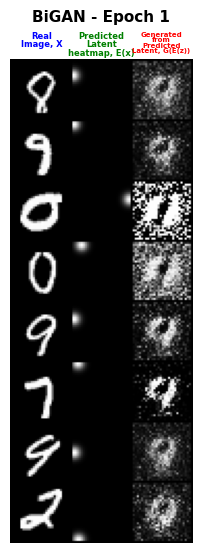

Epoch 2: D_loss=1.224, G_loss=1.994


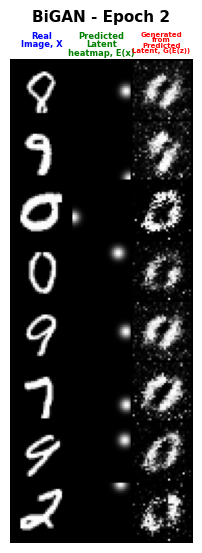

Epoch 3: D_loss=1.198, G_loss=2.054


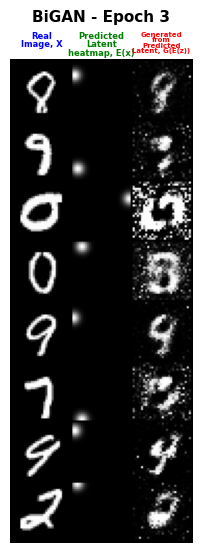

Epoch 4: D_loss=1.166, G_loss=2.229


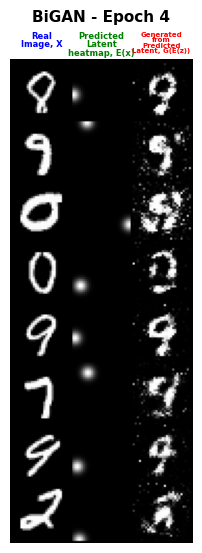

Epoch 5: D_loss=1.157, G_loss=2.254


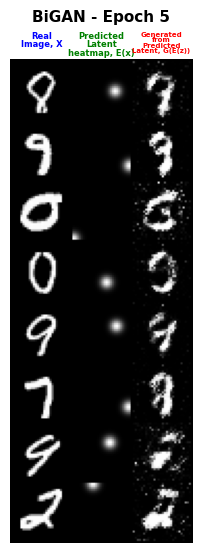

Epoch 6: D_loss=1.116, G_loss=2.412


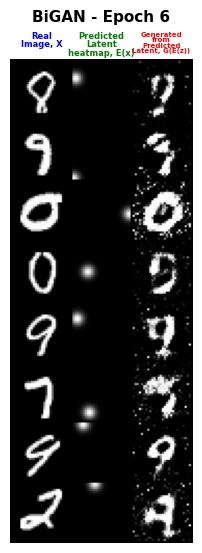

Epoch 7: D_loss=1.107, G_loss=2.484


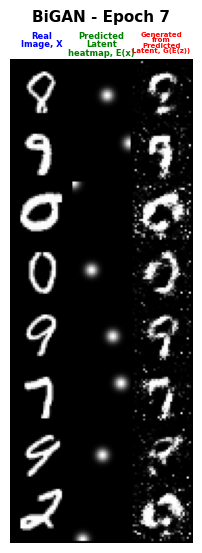

Epoch 8: D_loss=1.103, G_loss=2.459


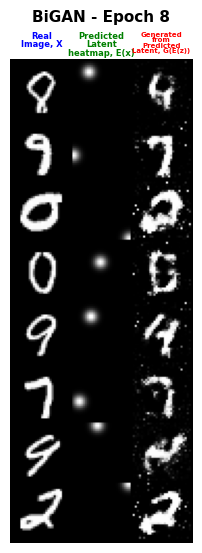

Epoch 9: D_loss=1.104, G_loss=2.474


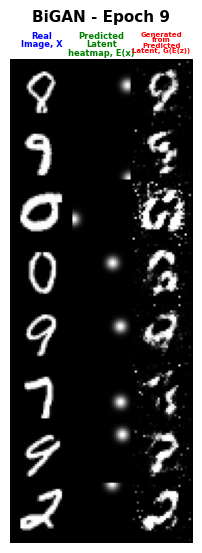

Epoch 10: D_loss=1.090, G_loss=2.515


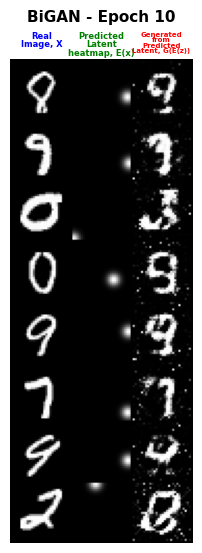

Epoch 11: D_loss=1.107, G_loss=2.444


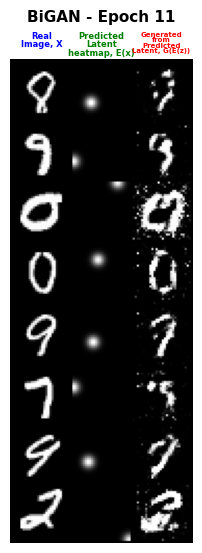

Epoch 12: D_loss=1.104, G_loss=2.444


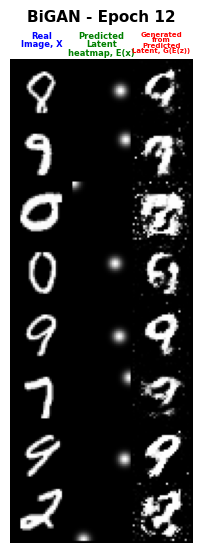

Epoch 13: D_loss=1.110, G_loss=2.425


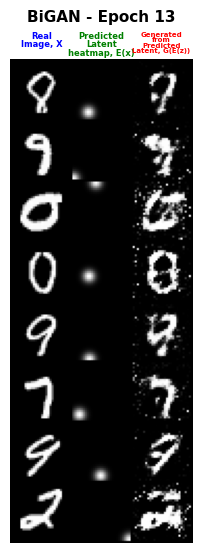

Epoch 14: D_loss=1.115, G_loss=2.384


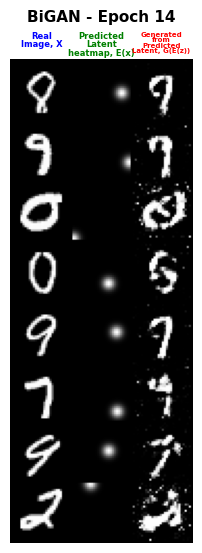

Epoch 15: D_loss=1.118, G_loss=2.381


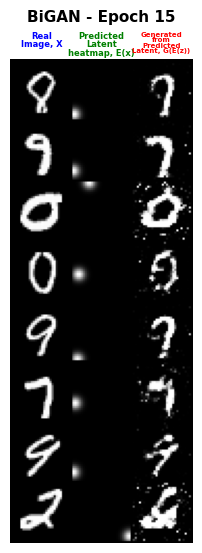

Epoch 16: D_loss=1.126, G_loss=2.360


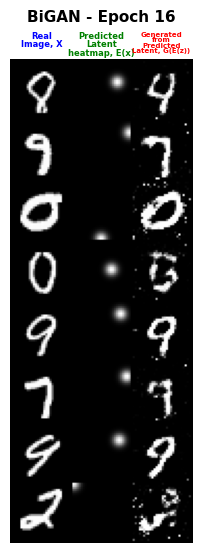

Epoch 17: D_loss=1.128, G_loss=2.345


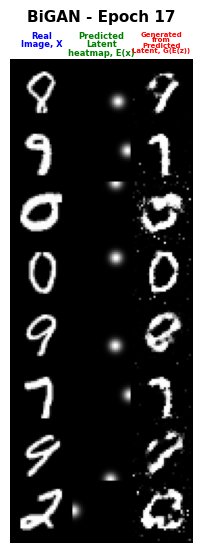

Epoch 18: D_loss=1.129, G_loss=2.353


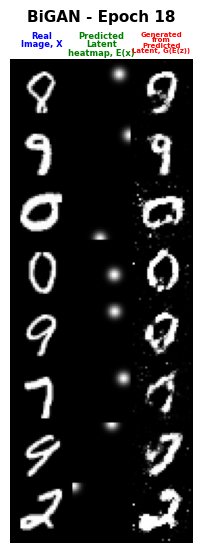

Epoch 19: D_loss=1.119, G_loss=2.373


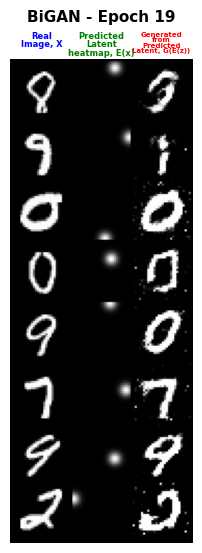

Epoch 20: D_loss=1.125, G_loss=2.371


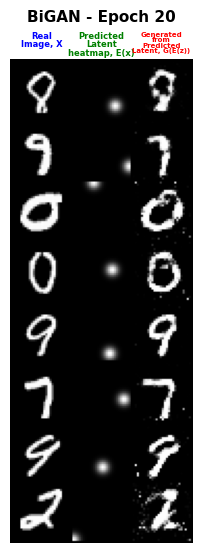

Epoch 21: D_loss=1.123, G_loss=2.376


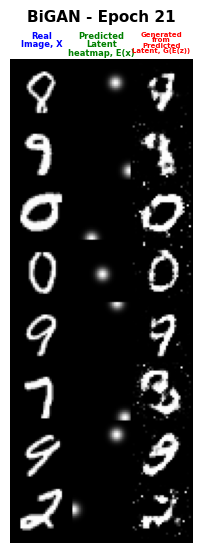

Epoch 22: D_loss=1.127, G_loss=2.386


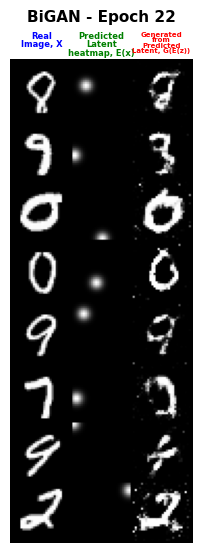

Epoch 23: D_loss=1.121, G_loss=2.392


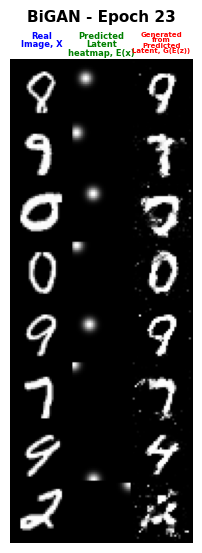

Epoch 24: D_loss=1.125, G_loss=2.383


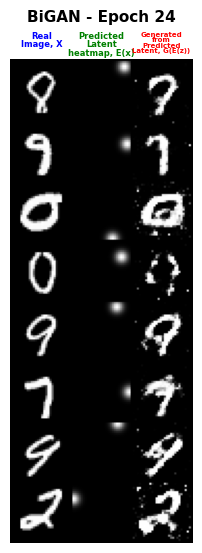

Epoch 25: D_loss=1.124, G_loss=2.392


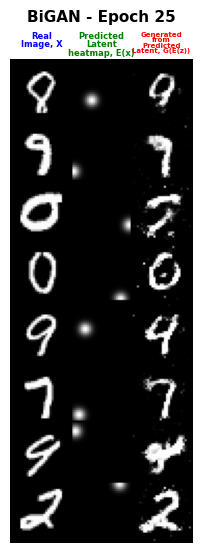

Epoch 26: D_loss=1.124, G_loss=2.397


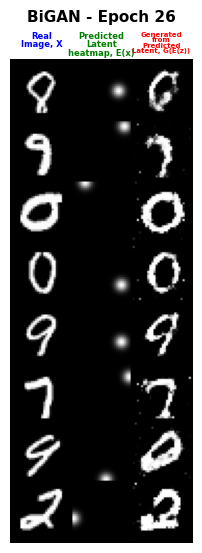

Epoch 27: D_loss=1.114, G_loss=2.421


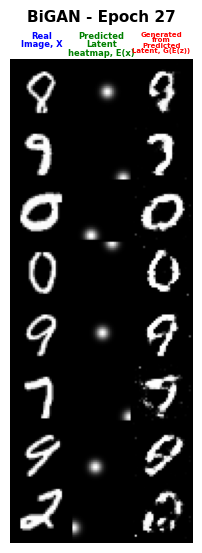

Epoch 28: D_loss=1.125, G_loss=2.400


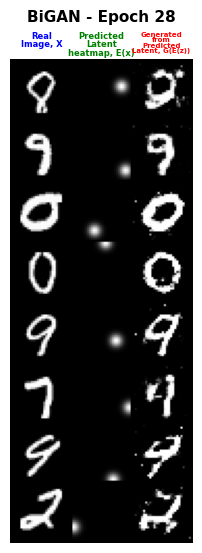

Epoch 29: D_loss=1.131, G_loss=2.397


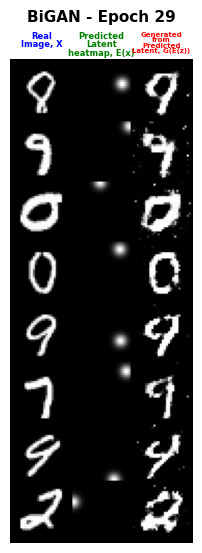

Epoch 30: D_loss=1.131, G_loss=2.392


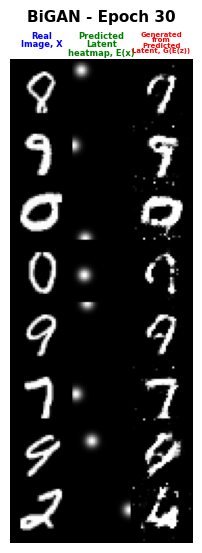

Epoch 31: D_loss=1.130, G_loss=2.395


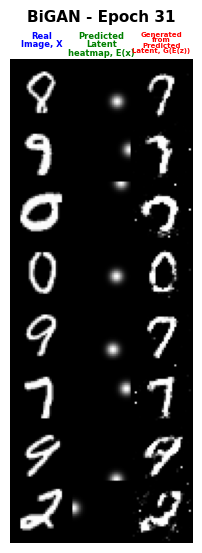

Epoch 32: D_loss=1.128, G_loss=2.401


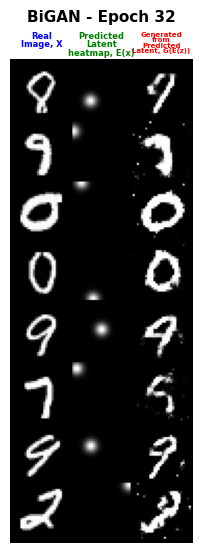

Epoch 33: D_loss=1.137, G_loss=2.374


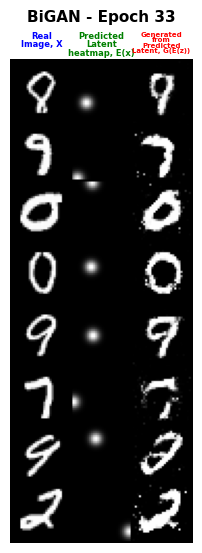

Epoch 34: D_loss=1.134, G_loss=2.386


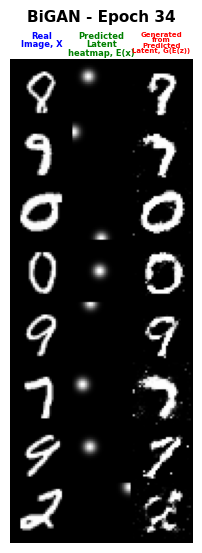

Epoch 35: D_loss=1.131, G_loss=2.398


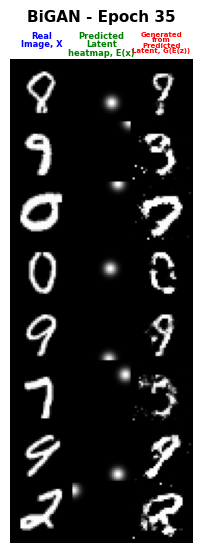

Epoch 36: D_loss=1.135, G_loss=2.383


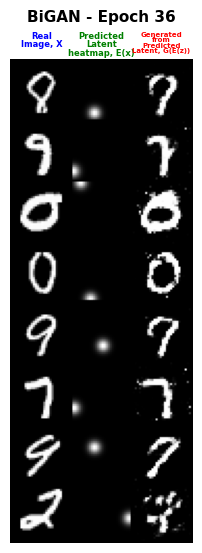

Epoch 37: D_loss=1.138, G_loss=2.380


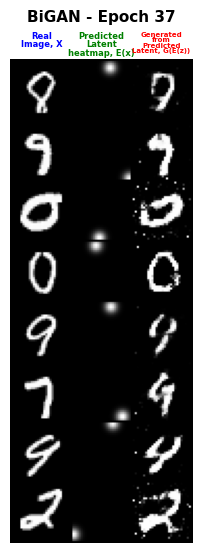

Epoch 38: D_loss=1.139, G_loss=2.383


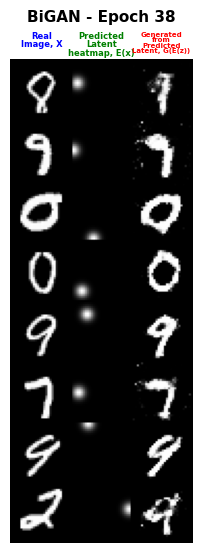

Epoch 39: D_loss=1.140, G_loss=2.372


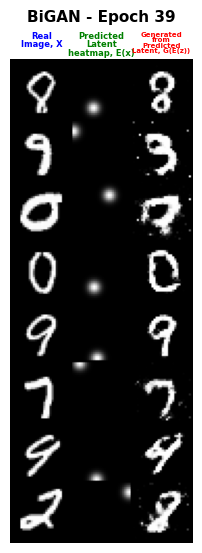

Epoch 40: D_loss=1.139, G_loss=2.370


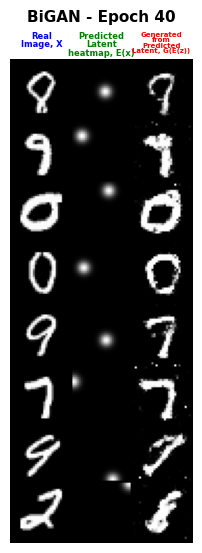

Epoch 41: D_loss=1.143, G_loss=2.371


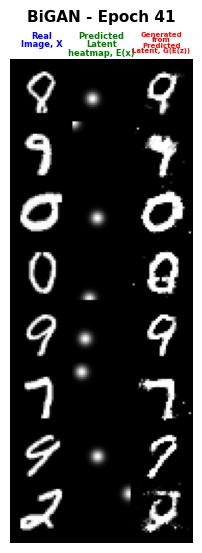

Epoch 42: D_loss=1.148, G_loss=2.352


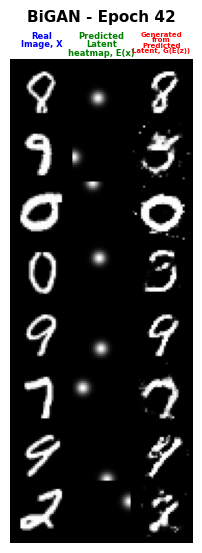

Epoch 43: D_loss=1.145, G_loss=2.381


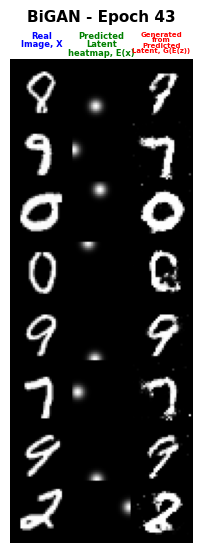

Epoch 44: D_loss=1.144, G_loss=2.374


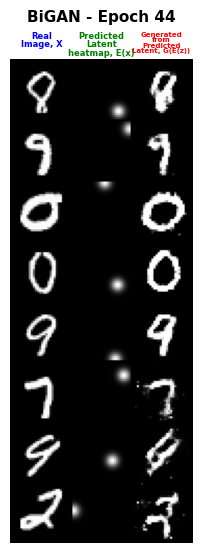

Epoch 45: D_loss=1.154, G_loss=2.352


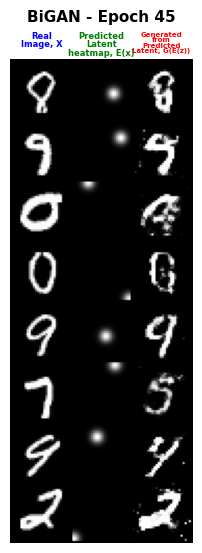

Epoch 46: D_loss=1.152, G_loss=2.344


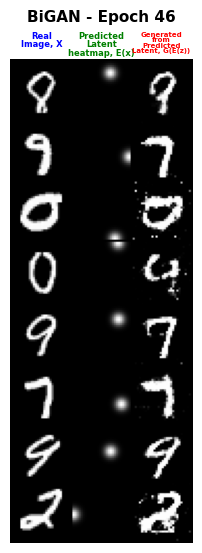

Epoch 47: D_loss=1.151, G_loss=2.345


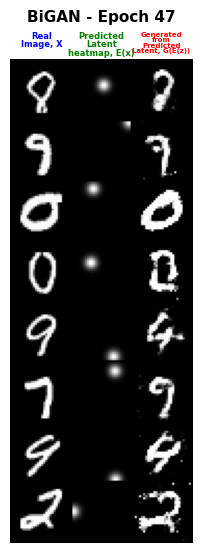

Epoch 48: D_loss=1.158, G_loss=2.329


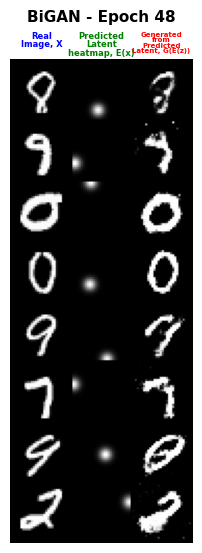

Epoch 49: D_loss=1.157, G_loss=2.331


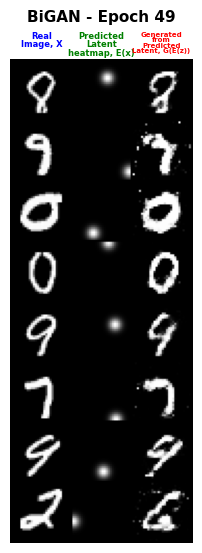

Epoch 50: D_loss=1.158, G_loss=2.330


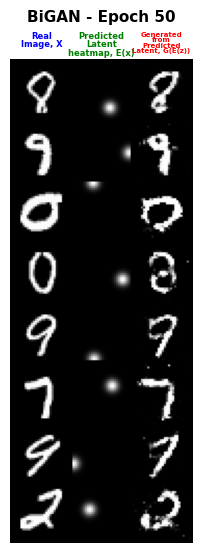

Training complete!


In [12]:
# =====================
# Train the Model!
# =====================
print("=" * 50)
print("Training BiGAN")
print("=" * 50)
train_gan(train_dataloader, fixed_noise, fixed_real, num_epochs=50, D_step=1, G_step=1)
print("Training complete!")